# Poisson Regression

This tutorial shows how to train several Generalized Linear Models (GLM) with scikit-learn, quantize them and run them in FHE using Concrete ML. We make use of strong quantization to ensure the accumulator of the linear part does not overflow when computing in FHE (7-bit accumulator). We show that conversion to FHE does not degrade performance with respect to the quantized model working on values in the clear.

Remark that, contrarily to other models like LinearRegression, a GLM for FHE has currently not been integrated in Concrete ML so we've to define here explicitely, in this notebook.

### Import libraries

We import scikit-learn libraries and Concrete Numpy quantization tools:

In [1]:
from copy import deepcopy

import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from concrete.ml.quantization import QuantizedArray, QuantizedExp, QuantizedLinear, QuantizedModule

And finally we import some helpers for visualization:

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import display

### Insurance claims dataset

In this tutorial, we show how to build a regression model that predicts the frequency of incidents in an insurance setting.

We download a data set from OpenML that contains 670,000 examples giving the frequency of car accidents for drivers of various ages, past accident history, car type, car color, geographical region, etc. We take only the first 50 000 examples to speed up training.


In [3]:
df, _ = fetch_openml(
    data_id=41214, as_frame=True, cache=True, data_home="~/.cache/sklean", return_X_y=True
)
df = df.head(50000)

The target variable is the number of claims per year, which is computed by the following formula :

In [4]:
df["Frequency"] = df["ClaimNb"] / df["Exposure"]

Let's visualize our data set, showing that the target variable, "Frequency" has a poisson distribution !

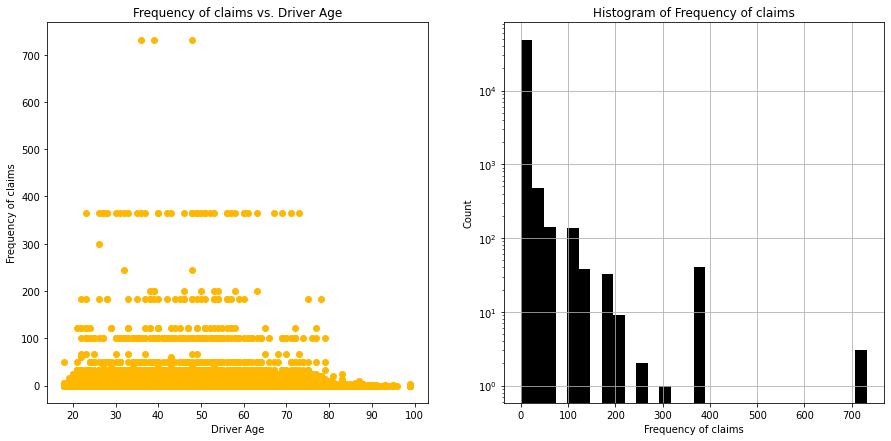

In [5]:
plt.ioff()
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
fig.patch.set_facecolor("white")
ax[0].set_title("Frequency of claims vs. Driver Age")
ax[0].set_xlabel("Driver Age")
ax[0].set_ylabel("Frequency of claims")
ax[0].scatter(df["DrivAge"], df["Frequency"], marker="o", color="#ffb700")
ax[1].set_title("Histogram of Frequency of claims")
ax[1].set_xlabel("Frequency of claims")
ax[1].set_ylabel("Count")
df["Frequency"].hist(bins=30, log=True, ax=ax[1], color="black")
display(fig)

We split the data into a training and a test set, but we also keep a part of the data to be used for calibration. This calibration set is not used for training, nor for testing the model. Thus we ensure better generalization of the quantized model.

In [6]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)
df_calib, df_test = train_test_split(df_test, test_size=100, random_state=0)

## Simple single variable insurance incident frequency predictor

Our initial example only uses a single predictor feature, so we can easily visualize results. 

We first train the scikit-learn PoissonRegressor model:

In [7]:
reg = PoissonRegressor(max_iter=300)
reg.fit(df_train["DrivAge"].values.reshape(-1, 1), df_train["Frequency"]);

We can now test this predictor on the test data:

In [8]:
test_data = np.sort(df_test["DrivAge"].values).reshape(-1, 1)
predictions = reg.predict(test_data)

Let's visualize our predictions to see how our model performs !

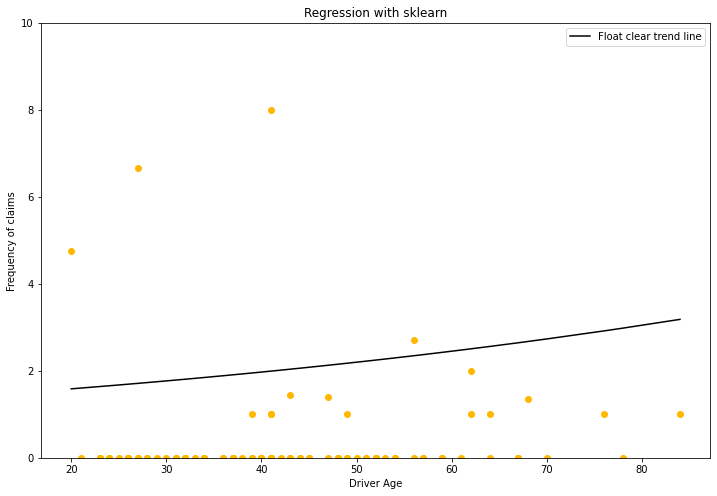

In [9]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
ax.plot(test_data, predictions, color="black", label="Float clear trend line")
ax.scatter(df_test["DrivAge"], df_test["Frequency"], marker="o", color="#ffb700")
ax.set_xlabel("Driver Age")
ax.set_ylim(0, 10)
ax.set_title("Regression with sklearn")
ax.set_ylabel("Frequency of claims")
ax.legend(loc="upper right")
display(fig)

### Analysis

The trend line obtained from the model suggests an increase of incidents with driver age, but the data shows that incidents peak around the ages of 30 to 40 years of age with a decrease afterwards. This simple model does not seem to be a good one. We convert it to FHE to show visually some details of the conversion. In the second part of this example we train a more powerful model.

### FHE models need to be quantized, so let's define a **Quantized Poisson Regressor**

We use the quantization primitives available in the Concrete library: QuantizedArray, QuantizedOp, and QuantizedLinear to define a Poisson Regressor which is a Generalized Linear Model with exponential link.

In [10]:
class QuantizedGLM(QuantizedModule):
    def __init__(self, n_bits, sklearn_model, calibration_data) -> None:
        super().__init__(["module_input"], ["invlink"], {})

        # Create a QuantizedLinear layer
        self.n_bits = n_bits

        self.q_inputs = [QuantizedArray(n_bits, calibration_data)]

        q_weights = QuantizedArray(2, np.expand_dims(sklearn_model.coef_, 1), is_signed=False)
        q_bias = QuantizedArray(1, sklearn_model.intercept_)
        q_layer = QuantizedLinear(6, q_weights, q_bias)
        quant_layers_dict = {}
        # Calibrate and get new calibration_data for next layer/activation
        calibration_data = self._calibrate_and_store_layers_activation(
            "module_input", "linear", q_layer, calibration_data, quant_layers_dict
        )

        # Create a new quantized layer (based on type(layer))
        q_exp = QuantizedExp(n_bits=7)
        calibration_data = self._calibrate_and_store_layers_activation(
            "linear", "invlink", q_exp, calibration_data, quant_layers_dict
        )

        self.quant_layers_dict = quant_layers_dict

    def _calibrate_and_store_layers_activation(
        self, layer_input, name, q_function, calibration_data, quant_layers_dict
    ):
        # Calibrate the output of the layer
        q_function.calibrate(calibration_data)
        # Store the learned quantized layer
        quant_layers_dict[name] = ((layer_input,), q_function)
        # Create new calibration data (output of the previous layer)
        q_calibration_data = QuantizedArray(self.n_bits, calibration_data)
        # Dequantize to have the value in clear and ready for next calibration
        return q_function(q_calibration_data).dequant()

    def quantize_input(self, *values):
        q_input_arr = deepcopy(self.q_inputs[0])
        q_input_arr.update_values(values[0])
        return q_input_arr

### We can now convert the scikit-learn model to our quantized version

First, we get the calibration data, and we then run it through the non-quantized (float) model to determine all possible intermediate values. After each operation, these values are quantized and the quantized version of the operations are stored in the QuantizedGLM module.

In [11]:
calib_data = np.expand_dims(df_calib["DrivAge"].values, 1)
n_bits = 5
q_glm = QuantizedGLM(n_bits, reg, calib_data)

Once the model's parameters and input ranges are quantized, we can quantize our test data and perform quantized inference. 

In [12]:
q_test_data = q_glm.quantize_input(test_data)
y_pred = q_glm.forward_and_dequant(q_test_data.qvalues)

Let's visualize the results of the quantized model. We can measure the goodness of fit on the test data using the Poisson deviance. We then plot the two trend lines (float value model and quantized model) to check for differences. 

In [13]:
from sklearn.metrics import mean_poisson_deviance

y_gt = df_test["Frequency"]
gt_weight = df_test["Exposure"]

dev_real = mean_poisson_deviance(y_gt, predictions, sample_weight=gt_weight)
dev_q = mean_poisson_deviance(y_gt, y_pred, sample_weight=gt_weight)

print(f"mean Poisson deviance (float): {dev_real}")
print(f"mean Poisson deviance (quant): {dev_q}")

mean Poisson deviance (float): 3.711521947502187
mean Poisson deviance (quant): 3.716861851757302


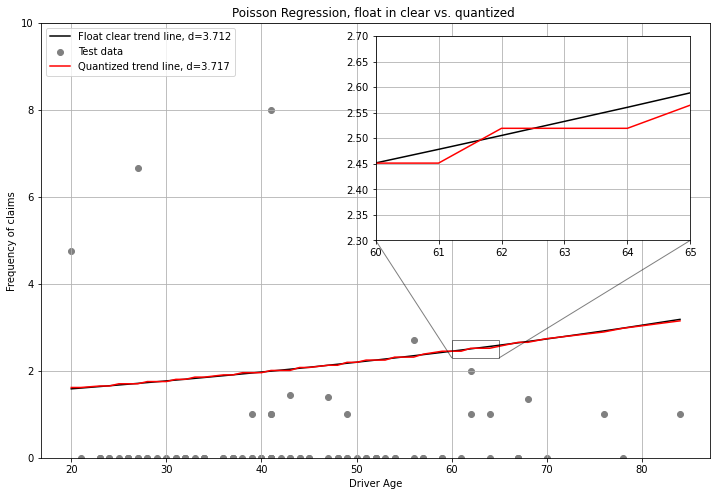

In [14]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
# ax.set_yscale("log")
ax.plot(test_data, predictions, color="black", label=f"Float clear trend line, d={dev_real:.3f}")
ax.scatter(df_test["DrivAge"], df_test["Frequency"], marker="o", color="gray", label="Test data")
ax.set_xlabel("Driver Age")
ax.set_ylim(0, 10)
ax.set_title("Poisson Regression, float in clear vs. quantized ")
ax.set_ylabel("Frequency of claims")
ax.plot(test_data, y_pred, color="red", label=f"Quantized trend line, d={dev_q:.3f}")
ax.legend(loc="upper left")
ax.grid()

# inset axes....
axins = ax.inset_axes([0.5, 0.5, 0.47, 0.47])
axins.plot(test_data, predictions, color="black", label=f"Float clear trend line, d={dev_real:.3f}")
axins.plot(test_data, y_pred, color="red", label=f"Quantized trend line, d={dev_q:.3f}")
# sub region of the original image
x1, x2, y1, y2 = 60, 65, 2.3, 2.7
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
# axins.set_xticklabels([])
# axins.set_yticklabels([])
axins.grid()
ax.indicate_inset_zoom(axins, edgecolor="black")

display(fig)

### Analysis

We see, in the graph above, that the trend line of the quantized model is more jaggy and has slightly higher deviance. The tradeoff between better fit and compatibility with FHE compilation needs to be made by the practitioner.

### Now it's time to make the inference homomorphic. Compiling a model to FHE is done with a single line of code


In [15]:
engine = q_glm.compile(q_test_data)

And now we can test the model on the test set in FHE:

In [16]:
y_pred_fhe = np.zeros((test_data.shape[0],), np.float32)
for i, test_sample in enumerate(tqdm(q_test_data.qvalues)):
    q_sample = np.expand_dims(test_sample, 1).transpose([1, 0]).astype(np.uint8)
    q_pred_fhe = engine.run(q_sample)
    y_pred_fhe[i] = q_glm.dequantize_output(q_pred_fhe)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:13<00:00,  1.35it/s]


Finally we check if there are any differences to the quantized model on non-encrypted clear data by plotting the trend lines. Sometimes, FHE noise can create minor artifacts.

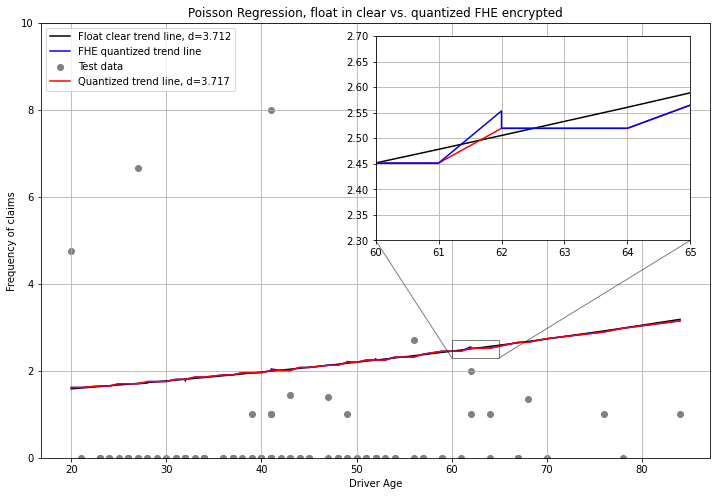

In [17]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
ax.plot(test_data, predictions, color="black", label=f"Float clear trend line, d={dev_real:.3f}")
ax.plot(test_data, y_pred_fhe, color="blue", label="FHE quantized trend line")
ax.scatter(df_test["DrivAge"], df_test["Frequency"], marker="o", color="gray", label="Test data")
ax.set_xlabel("Driver Age")
ax.set_ylim(0, 10)
ax.set_title("Poisson Regression, float in clear vs. quantized FHE encrypted")
ax.set_ylabel("Frequency of claims")
ax.plot(test_data, y_pred, color="red", label=f"Quantized trend line, d={dev_q:.3f}")
ax.legend(loc="upper left")
ax.grid()

axins = ax.inset_axes([0.5, 0.5, 0.47, 0.47])
axins.plot(test_data, predictions, color="black", label=f"Float clear trend line, d={dev_real:.3f}")
axins.plot(test_data, y_pred, color="red", label=f"Quantized FHE trend line, d={dev_q:.3f}")
axins.plot(test_data, y_pred_fhe, color="blue", label="FHE quantized trend line")
x1, x2, y1, y2 = 60, 65, 2.3, 2.7
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.grid()
ax.indicate_inset_zoom(axins, edgecolor="black")

display(fig)

## A multi-variate model

The simple single variable model does not achieve good results (age is not a good predictor for the number of claims). Let's train a model with all of our predictor variables. We proceed by transforming the raw features into ones that can be input to a regression model. Thus, the categorical features are transformed into one-hot encoding, but we also reduce the resolution of vehicle and person by binning. Transforming the data this way, we end up with a total of 57 continuous features (instead of the initial 11).

Here is where we encounter one of the limitations of our framework. We perform a dot product in the prediction, in the QuantizedLinear class, but in our framework the maximum integer size is, for now, limited to 7 bits. As every multiplication doubles the number of bits of precision of the inputs performing 57 multiplication-additions of integers to compute w.x would quickly overflow 7 bits. 

As a workaround to the limited accumulator resolution, we perform PCA to reduce dimensionality from 57 to 14 dimensions and train our multi-variate model in this reduced dimensionality space. However, we also train a reference model on all of the original features. 

In [18]:
import warnings

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    KBinsDiscretizer,
    OneHotEncoder,
    StandardScaler,
)

warnings.filterwarnings("ignore")

log_scale_transformer = make_pipeline(FunctionTransformer(np.log, validate=False), StandardScaler())

linear_model_preprocessor = ColumnTransformer(
    [
        ("passthrough_numeric", "passthrough", ["BonusMalus"]),
        ("binned_numeric", KBinsDiscretizer(n_bins=10), ["VehAge", "DrivAge"]),
        ("log_scaled_numeric", log_scale_transformer, ["Density"]),
        (
            "onehot_categorical",
            OneHotEncoder(sparse=False),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
    ],
    remainder="drop",
)

poisson_glm = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", PoissonRegressor(alpha=1e-12, max_iter=300)),
    ]
)

poisson_glm_pca = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("pca", PCA(n_components=14, whiten=True)),
        ("regressor", PoissonRegressor(alpha=1e-12, max_iter=300)),
    ]
)

poisson_glm.fit(df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"])

poisson_glm_pca.fit(df_train, df_train["Frequency"], regressor__sample_weight=df_train["Exposure"]);

### Now we evaluate the new models

In [19]:
def score_estimator(y_pred, y_gt, gt_weight):
    """Score an estimator on the test set."""
    y_pred = np.squeeze(y_pred)
    dev = mean_poisson_deviance(y_gt, y_pred, sample_weight=gt_weight)
    return dev


def score_sklearn_estimator(estimator, df_test):
    """A wrapper to score a sklearn pipeline on a dataframe"""
    return score_estimator(estimator.predict(df_test), df_test["Frequency"], df_test["Exposure"])


def score_concrete_glm_estimator(poisson_glm_pca, q_glm: QuantizedGLM, df_test):
    """A wrapper to score QuantizedGLM on a dataframe, transforming the dataframe using
    a sklearn pipeline
    """
    test_data = poisson_glm_pca["pca"].transform(poisson_glm_pca["preprocessor"].transform(df_test))
    q_test_data = q_glm.quantize_input(test_data).qvalues
    y_pred = q_glm.forward_and_dequant(q_test_data)
    return score_estimator(y_pred, df_test["Frequency"], df_test["Exposure"])


print(f"PoissonRegressor evaluation: {score_sklearn_estimator(poisson_glm, df_test):.4f}")
print(f"PoissonRegressor+PCA evaluation: {score_sklearn_estimator(poisson_glm_pca, df_test):.4f}")

PoissonRegressor evaluation: 1.3773
PoissonRegressor+PCA evaluation: 1.4370


### Test the multi-variate GLM with multiple quantization bit-widths

In [20]:
# Now, get calibration data from the held out set
calib_data = poisson_glm_pca["pca"].transform(poisson_glm_pca["preprocessor"].transform(df_calib))

# Let's see how performance decreases with bit-depth.
# This is just a test of our quantized model, not in FHE
n_bits_test = np.asarray([28, 16, 6, 5, 4, 3, 2])
dev_bits_test = np.zeros_like(n_bits_test, dtype=np.float32)
for i, n_bits in enumerate(n_bits_test):
    q_glm = QuantizedGLM(n_bits, poisson_glm_pca["regressor"], calib_data)
    dev_bits_test[i] = score_concrete_glm_estimator(poisson_glm_pca, q_glm, df_test)

We plot the Poisson deviance with respect to the quantized bit-width, to show how performance degrades with quantization:

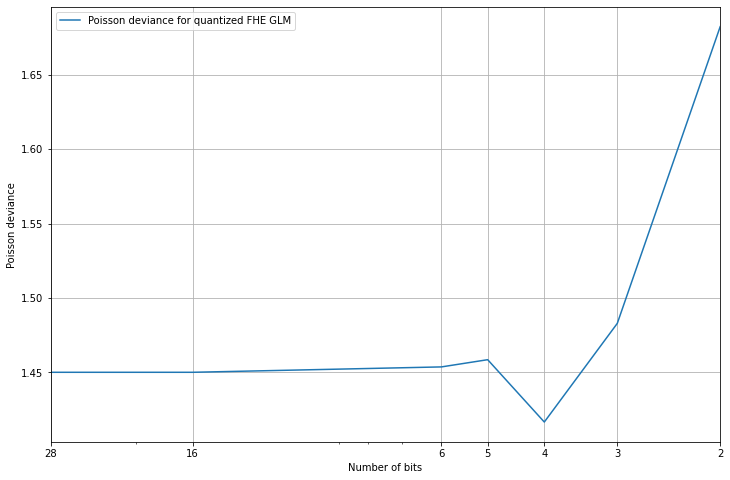

In [21]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
ax.plot(n_bits_test, dev_bits_test, label="Poisson deviance for quantized FHE GLM")
ax.set_xlim(2, 28)
ax.invert_xaxis()
ax.set_xlabel("Number of bits")
ax.set_ylabel("Poisson deviance")
ax.set_xscale("log")
ax.set_xticks(n_bits_test)
ax.set_xticklabels([str(k) for k in n_bits_test])
ax.grid()
ax.legend(loc="upper left")
display(fig)

### Analysis

While the prediction quality is mostly stable until 6 bits, we see a decrease in prediction performance in lower bit-widths. For 4 bits the performance seems to improve, but this is probably just a lucky sampling of the data, as this graph shows a single experiment. We expect to have a smooth increase of the deviance with lower bit-width when running the experiment multiple times.

With 14 features, we can have weights and data in at most 2 bits. 

We now choose an operating point that is compatible with FHE: 2 bit quantization.

In [22]:
q_glm = QuantizedGLM(2, poisson_glm_pca["regressor"], calib_data)
test_data = poisson_glm_pca["pca"].transform(poisson_glm_pca["preprocessor"].transform(df_test))
q_test_data = q_glm.quantize_input(test_data)

### Compile the multi-variate GLM to FHE. Again, with a single line of code we compile to FHE:

In [23]:
engine = q_glm.compile(q_test_data)

Finally, we evaluate the model on encrypted data:

In [24]:
y_pred_fhe = np.zeros((test_data.shape[0],), np.float32)
for i, test_sample in enumerate(tqdm(q_test_data.qvalues)):
    q_sample = np.expand_dims(test_sample, 1).transpose([1, 0]).astype(np.uint8)
    q_pred_fhe = engine.run(q_sample)
    y_pred_fhe[i] = q_glm.dequantize_output(q_pred_fhe)

dev_pca_quantized_fhe = score_estimator(y_pred_fhe, df_test["Frequency"], df_test["Exposure"])

print(f"PoissonRegressor evaluation: {score_sklearn_estimator(poisson_glm, df_test):.4f}")
print(f"PoissonRegressor+PCA evaluation: {score_sklearn_estimator(poisson_glm_pca, df_test):.4f}")
print(f"FHE Quantized deviance: {dev_pca_quantized_fhe:.4f}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:55<00:00,  1.15s/it]

PoissonRegressor evaluation: 1.3773
PoissonRegressor+PCA evaluation: 1.4370
FHE Quantized deviance: 1.6806


## Conclusion

In this tutorial, we have discussed how we can use Concrete Numpy to convert a scikit-learn based Poisson regression model to FHE. 

First of all, we have shown that with the proper choice of pipeline and parameters, we can do the conversion with little loss of precision. This decrease in the quality of prediction is due to quantization of model weights and input data, and some minor noise can appear due to FHE. This noise is visible on the single variable FHE trend line as minor deviations of the blue curve with respect to the red one. 

Finally, we have shown how conversion of a model to FHE can be done with a single line of code and how quantization is aided by the tools in Concrete Numpy. 
